# Simple Tree

---
## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver
import re              # Regular Expressions

In [2]:
import pydotplus
from IPython.display import Image
from sklearn import metrics, tree

In [3]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

### Database

In [4]:
zip_filename = "../../data/ee-insee-2005_custom-sqlite.zip"
eedb = zip_filename.replace("-sqlite.zip", ".sqlite")

if not os.path.exists(eedb):
    with zipfile.ZipFile(zip_filename) as zip_file:
        zip_file.extractall("../../data/")

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM eec05_custom"
    eec05 = pd.read_sql_query(query, con)

In [6]:
# # Create a ("female" x "enfant") interaction variable
# bool_ = eec05[["enfants_", "female_"]].astype(bool)
# eec05["female_enfants_"] = (bool_.enfants_ & bool_.female_).astype(int)

# # Drop data we don't need
# eec05 = eec05[eec05.age60_ == 0]
# eec05 = eec05.drop("age60_", 1)

---
## Simple Tree

In [7]:
# Build a list of parameters to include in the model, using regex
# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
filters = {
#     "trim": "^trim$",
    "age": "^age$",
    "female": "^female_$",
    
#     "nationalite": "^nat28_[0-9]*_$",
#     "matri": "^matri_[0-9]*_$",
#     "enfants": "^nbenf18_[0-9]*_$",
    
#     "diploma": "^dip_[0-9]*_$",
#     "specialite": "^spe_[0-9]*_$",
    
#     "region": "^reg_[0-9]*_$",
    "unite_urbaine": "^tur5_[0-9]*_",
    
#     "csp_pere": "^cspp_[0-9]*_$",
#     "csp": "^cstot_[0-9]*_$"
}

params = {k: sorted([x for x in eec05.columns if re.match(r, x)]) for (k, r) in filters.items()}

# Avoid the dummy variable trap
params = {k: (v if len(v) == 1 else v[:-1]) for (k, v) in params.items()}
# params["region"] += ["region2_"]

In [8]:
trims = ["t{}".format(x) for x in sorted(eec05["trim"].unique())]
eec05_ = {t: eec05[eec05.trim == int(t[1])] for t in trims}
X = {t: eec05_[t][sum(params.values(), [])] for t in eec05_}
y = {t: eec05_[t]["actop_"] for t in eec05_}

### Train the model using `trim=1` data

In [9]:
# Create & fit the tree
simple_tree_sk = tree.DecisionTreeClassifier(max_depth=9, random_state=0).fit(X["t1"], y["t1"])

#X_combined = np.vstack((X_, X_test2))
#Y_combined = np.hstack((Y_, y_test2))

In [10]:
# Check the accuracy of the model on the training set
print "Accuracy: {}".format(simple_tree_sk.score(X["t1"], y["t1"]))

Accuracy: 0.822033426184


In [11]:
# Create a graphical representation of the tree
dot_data = tree.export_graphviz(
    simple_tree_sk,
    out_file=None,
    feature_names=X["t1"].columns,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data)

# Save the graph to a .png file
png_file = "img/simple_tree.png"
graph.write_png(png_file)

True

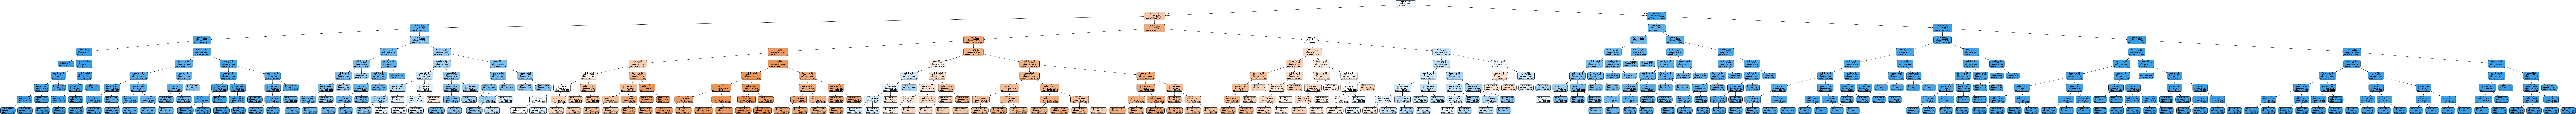

In [12]:
# Load and display the graph from file
Image(png_file)

### Apply the model to test data (`trim=2/3/4`)

In [13]:
# Check the accuracy of the model on the training & test sets

for t in trims:
#     predicted = simple_tree_sk.predict_proba(X[t]).T[1]
#     predicted = np.where(predicted < 0.5, 0, 1)
    predicted = simple_tree_sk.predict(X[t])
    print "Accuracy ({}): {}".format(t, metrics.accuracy_score(y[t], predicted))

# Note: the two methods for computing `predicted` are equivalent (THRESHOLD = 0.5)

Accuracy (t1): 0.822033426184
Accuracy (t2): 0.821240561711
Accuracy (t3): 0.816863909653
Accuracy (t4): 0.816484687851


---
## Marginal Effects

In [14]:
marginal_effects = pd.DataFrame()

### By modifying the dataset ("passage de tout le monde en licence")

In [15]:
brute_force = pd.Series()
for category in filters:
    for pivot in params[category]:
        non_pivots = [x for x in params[category] if x != pivot]
        
        X_one = X["t1"].copy() 
        X_one[non_pivots] = 0
        X_one[pivot] = 1
        
        proba_one = simple_tree_sk.predict_proba(X_one).T[1].mean()
        proba_t1 = simple_tree_sk.predict_proba(X["t1"]).T[1].mean()
        brute_force[pivot] = proba_one - proba_t1

In [16]:
marginal_effects["brute_force"] = brute_force
marginal_effects.transpose()

age  tur5_1_  tur5_2_  tur5_3_  tur5_4_  female_
brute_force 0.4813 -0.0329  0.0004   0.0094   0.0142   0.0412

**TODO:** figure out what Bastien was trying to do with `X_3`

---
## Most important parameters
_ranked by **Gini importance**_ ("les plus clivantes")

In [17]:
gini = pd.DataFrame(simple_tree_sk.feature_importances_, index=X["t1"].columns, columns=['gini'])
gini.sort_values(by='gini', ascending=False).transpose()

age  female_  tur5_1_  tur5_4_  tur5_2_  tur5_3_
gini 0.9698 0.0216   0.0044   0.0018   0.0018   0.0007

---
## Odds Ratios

The odds ratios formula is:
$$\frac{p/(1-p)}{q/(1-q)} = \frac{p(1-q)}{q(1-p)}$$

where $p$ and $q$ are the probability of being **unemployed**.

In [18]:
odds = pd.Series()
for category in filters:
    for pivot in params[category]:
        non_pivots = [x for x in params[category] if x != pivot]
        
        X_one = X["t1"].copy() 
        X_one[non_pivots] = 0
        X_one[pivot] = 1

        proba_one = simple_tree_sk.predict_proba(X_one).T[1].mean()
        odds[pivot] = proba_one/(1-proba_one)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
odds_ratios = pd.DataFrame(index=odds.index, columns=odds.index)
for col in odds.index:
    for row in odds.index:
        odds_ratios[col][row] = odds[col]/odds[row]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


In [20]:
# odds_ratios     # col, row = odds[col]/odds[row]
odds_ratios.T   # row, col = odds[row]/odds[col]  

age tur5_1_ tur5_2_ tur5_3_ tur5_4_ female_
age      NaN   inf     inf     inf     inf     inf    
tur5_1_ 0.0000 1.0000  0.8752  0.8442  0.8284  0.7426 
tur5_2_ 0.0000 1.1425  1.0000  0.9645  0.9464  0.8484 
tur5_3_ 0.0000 1.1846  1.0368  1.0000  0.9813  0.8797 
tur5_4_ 0.0000 1.2072  1.0566  1.0191  1.0000  0.8965 
female_ 0.0000 1.3466  1.1786  1.1368  1.1155  1.0000